In [1]:
import torch
import pickle
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import utils
import random
import torchvision.utils as vutils

#### Explore attenion maps

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
torch.Size([10000, 3, 224, 224])


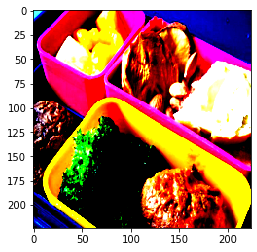

In [2]:
train_img = torch.load("cached_data/train_img")

print(train_img[0].size())
print(train_img.size())
plt.imshow((train_img[0].permute(1, 2, 0)))
plt.show()

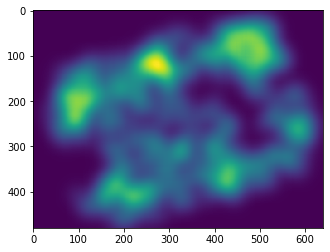

torch.Size([224, 224])


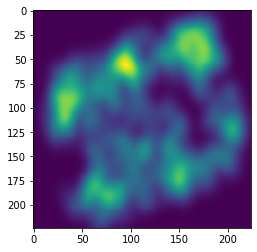

In [3]:
image_map  = 'dataset/maps/train/COCO_train2014_000000000009.png'

img = Image.open(image_map)
plt.imshow(img)
plt.show()
normalize = transforms.Normalize(mean=[0.485],
                                 std=[0.229])
transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

mask = transform(img).squeeze()
print(mask.size())

plt.imshow(mask)
plt.show()


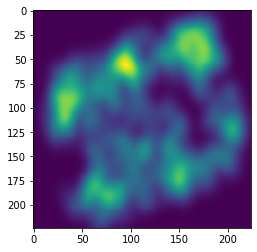

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


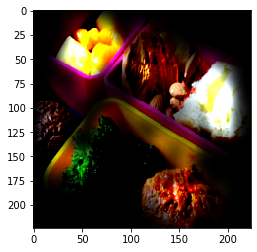

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


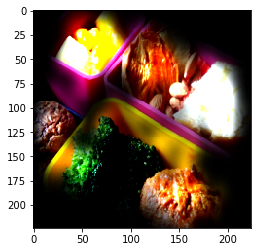

In [4]:
mask  = torch.from_numpy(np.fliplr(mask).copy())
plt.imshow(np.fliplr(mask))
plt.show()
result1 = torch.mul(train_img[0],mask)
result2 = torch.mul(1 + train_img[0],mask)

print(result1.size())
## output for specific channel
plt.imshow(result1.permute(1, 2, 0)) 
plt.show()
plt.imshow(result2.permute(1, 2, 0))

#### Extract feature maps

In [5]:
import vision_network
device = "cuda:0"
vision_net = vision_network.VisionNet(device)

timeline = "20191219-111227"
vision_net.model.load_state_dict(torch.load("models/enc1-%s" % timeline))
# model = torch.load("models/enc1-%s" % timeline)

<All keys matched successfully>

In [6]:
print(vision_net.model._modules.get('layer4'))
# print (vision_net.model)

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): 

In [7]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

torch.Size([64, 256, 56, 56])


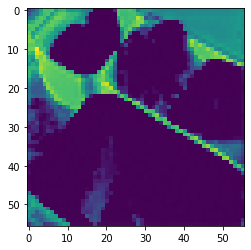

In [8]:
train_set = train_img[0:64]
# print(train_set.size())
# print(vision_net.forward(train_set.to(device)).size())
layer = 'layer1'

# print (vision_net.model)
vision_net.model.layer1.register_forward_hook(get_activation(layer))
output = vision_net.model(train_set.to(device))
# layer = model._modules.get('layer3')
print(activation[layer].size())

plt.imshow(activation[layer][0,0,:,:].cpu()) 
plt.show()


torch.Size([64, 256, 56, 56])


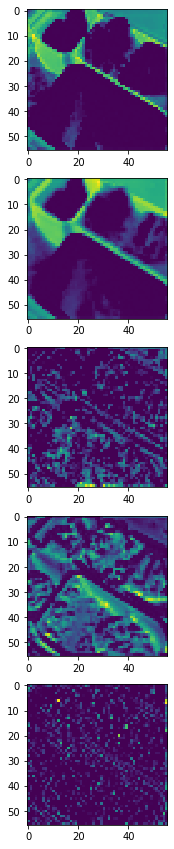

In [9]:
act = activation[layer].squeeze().cpu()
print(act.size())
fig, axarr = plt.subplots(5,figsize=(15,15))
for idx in range(5):
    axarr[idx].imshow(act[0,idx,:,:])

torch.Size([56, 56])


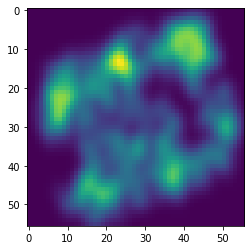

In [10]:
transform2 = transforms.Compose([
            transforms.Resize((56, 56)),
            transforms.ToTensor(),
        ])

mask2 = transform2(img).squeeze()
print(mask2.size())

# plt.imshow(np.fliplr(mask2))
mask2  = torch.from_numpy(np.fliplr(mask2).copy())
plt.imshow(np.fliplr(mask2))

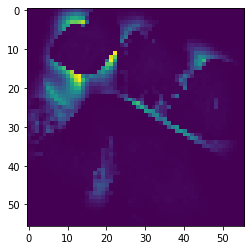

In [11]:
plt.imshow(torch.mul(act[0][0],mask2))

#### Create dataset with attention

In [12]:
def load_maps(which):
    
    from os import listdir
    from os.path import isfile, join
    mypath = "dataset/maps/%s" % which
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    
    import re
    m = re.search('COCO_%s2014_(.+?).png' % which, onlyfiles[0])
    index = []
    for item in onlyfiles:
        m = re.search('COCO_%s2014_(.+?).png' % which, item)
        if m:
            index.append(m.group(1))
    index.sort()
    
    mask = []
    for item in index:
        
        image_map  = 'dataset/maps/' + which + '/COCO_%s2014_' % which +item+'.png'

        img = Image.open(image_map)
        normalize = transforms.Normalize(mean=[0.485],
                                         std=[0.229])
        transform = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor()
                ])
        mask.append(transform(img).squeeze())
        
    result = torch.stack(mask)
    return result

In [13]:
train_maps = load_maps('train')

In [14]:
print(train_maps.size())

torch.Size([10000, 224, 224])


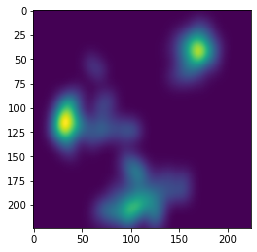

In [15]:
plt.imshow(train_maps[2])
plt.show()

In [12]:
def cache_dot(which):
    
    feature_maps = torch.load("cached_data/%s_img" % which)
    attent_maps = load_maps(which)
    products = []
    for i in range (feature_maps.size()[0]):
        products.append(torch.mul(feature_maps[i],attent_maps[i]))
    
    result = torch.stack(products)
    torch.save(result, "cached_data/%s_attention" % which)
    return result

In [13]:
# dots = cache_dot('val')
# print(dots.size())

In [14]:
# plt.imshow(dots[0].permute(1, 2, 0)[:,:,0]) 
# plt.show()

#### Test new_get_att

In [15]:
def new_get_att_maps(self, index):
    seed = np.random.randint(2147483647)  # make a seed with numpy generator
    norm_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    path, _ = self.samples[index]
    att_path = path.replace("train14/", "").replace("images", "maps").replace(".jpg", ".png")
    _att_map = Image.open(att_path)
    sample = self.loader(path)

    torch.manual_seed(seed)
    random.seed(seed)
    if self.transform is not None:
        sample = self.transform(sample)
        sample = norm_transform(sample)

    torch.manual_seed(seed)
    random.seed(seed)
    if self.transform is not None:
        _att_map = self.transform(_att_map)

    return sample, _att_map, path


In [16]:
datasets.ImageFolder.__getitem__ = new_get_att_maps

In [17]:
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder("dataset/images/train", transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])),
    batch_size=4, shuffle=True,
    num_workers=2, pin_memory=False)

plt.figure(figsize=(50, 50))


<Figure size 3600x3600 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224]) torch.Size([4, 224, 224])


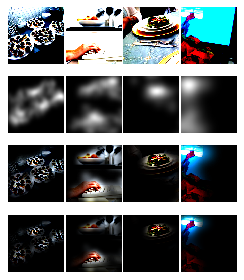

In [18]:
for i, batch in enumerate(train_loader):
    img, att_map, _ = batch
    plt.subplot(4, 1, 1)
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(img, padding=5, normalize=False, pad_value=255),
                            (1, 2, 0)))

    plt.subplot(4, 1, 2)
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(att_map, padding=5, normalize=False, pad_value=255),
                            (1, 2, 0)))
    plt.subplot(4, 1, 3)
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(torch.mul(img, att_map), padding=5, normalize=False, pad_value=255),
                            (1, 2, 0)))

    plt.subplot(4, 1, 4)
    plt.axis("off")
    print(img.size(), att_map.size(), img[:, 0, :, :].size())
    img[:, 0, :, :] = torch.mul(img[:, 0, :, :], att_map.squeeze())
    img[:, 1, :, :] = torch.mul(img[:, 1, :, :], att_map.squeeze())
    img[:, 2, :, :] = torch.mul(img[:, 2, :, :], att_map.squeeze())
#     plt.imshow(img[:, 0, :, :].permute(1, 2, 0))
#     plt.show()

    plt.imshow(np.transpose(vutils.make_grid(torch.mul(img, att_map), padding=5, normalize=False, pad_value=255),
                            (1, 2, 0)))

    plt.tight_layout()
    plt.savefig("fig.png")
    break